In [ ]:
#connect to gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Referensi: https://www.tensorflow.org/tutorials/images/transfer_learning

# Data Prep

In [ ]:
!pip install visualkeras
import numpy as np
import matplotlib.pyplot as plt
import visualkeras

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path dataset directory
dataset_dir = "/content/gdrive/MyDrive/Skripsi/Label"

# Define the paths training and validation directories
train_dir = "/Dataset/train"
val_dir = "/Dataset/validation/"

# Get the list of all class directories in the dataset directory
class_directories = [os.path.join(dataset_dir, class_dir) for class_dir in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_dir))]

# Create training and validation directories
for directory in [train_dir, val_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Iterate over each class directory
for class_dir in class_directories:
    # Get the list of image files in the current class directory
    image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(".jpg") or file.endswith(".png")]

    # Split the image files into training and validation sets
    train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

    # Get the class name from the class directory name
    class_name = os.path.basename(class_dir)

    # Create subdirectories for the class in the training and validation directories
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    for directory in [train_class_dir, val_class_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Move training images to the training class directory
    for file in train_files:
        shutil.copy(file, train_class_dir)

    # Move validation images to the validation class directory
    for file in val_files:
        shutil.copy(file, val_class_dir)

print("Dataset split into training and validation sets.")


Dataset split into training and validation sets.


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 800 files belonging to 4 classes.
Found 200 files belonging to 4 classes.


In [ ]:
#menampilkan 9 gambar petama pada directory train
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#membagi dataset validasi menjadi dataset validasi dan test
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 6
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#augmentasi dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

#Model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

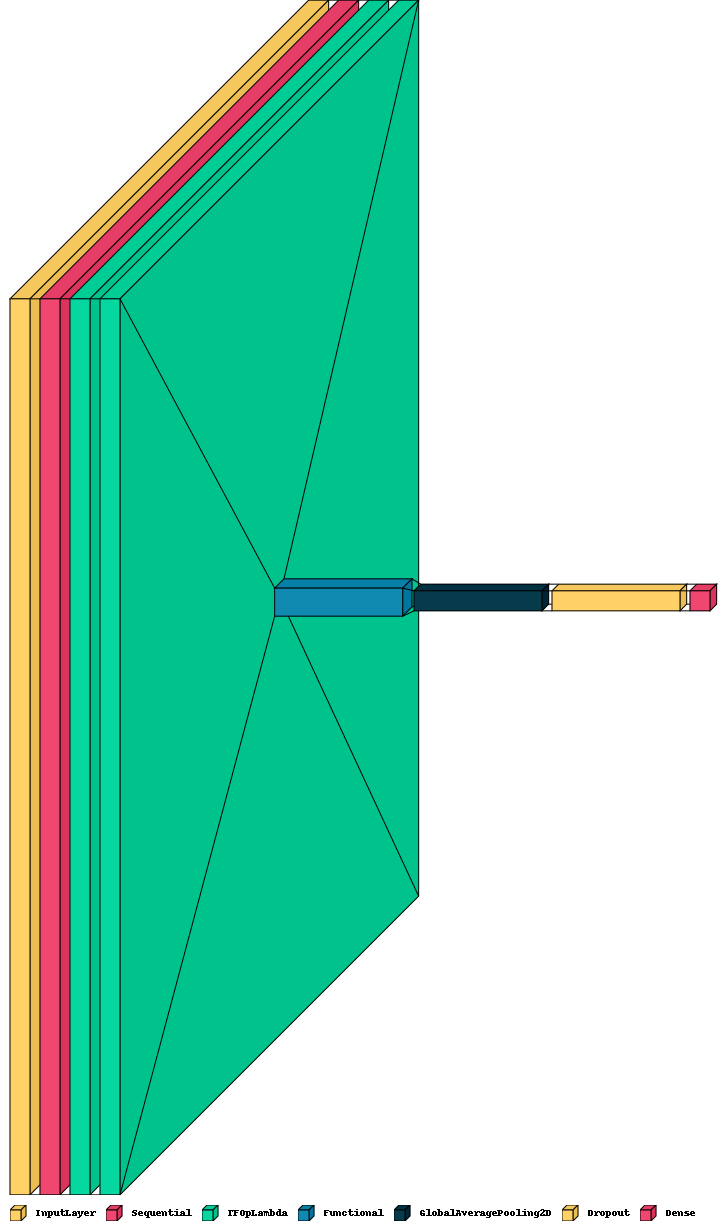

In [ ]:
import visualkeras

model.summary()
visualkeras.layered_view(model, legend=True)  # font is optional!

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 5s 175ms/step - loss: 1.9923 - accuracy: 0.1845


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
25/25 [==============================] - 13s 197ms/step - loss: 1.6966 - accuracy: 0.2763 - val_loss: 1.4002 - val_accuracy: 0.3512
Epoch 2/15
25/25 [==============================] - 9s 302ms/step - loss: 1.3313 - accuracy: 0.3887 - val_loss: 1.1101 - val_accuracy: 0.5060
Epoch 3/15
25/25 [==============================] - 7s 231ms/step - loss: 1.0641 - accuracy: 0.5625 - val_loss: 0.9024 - val_accuracy: 0.6369
Epoch 4/15
25/25 [==============================] - 10s 331ms/step - loss: 0.8743 - accuracy: 0.6600 - val_loss: 0.7701 - val_accuracy: 0.7143
Epoch 5/15
25/25 [==============================] - 8s 267ms/step - loss: 0.7807 - accuracy: 0.7100 - val_loss: 0.6846 - val_accuracy: 0.7321
Epoch 6/15
25/25 [==============================] - 10s 218ms/step - loss: 0.6911 - accuracy: 0.7588 - val_loss: 0.6083 - val_accuracy: 0.7738
Epoch 7/15
25/25 [==============================] - 9s 299ms/step - loss: 0.6099 - accuracy: 0.7900 - val_loss: 0.5432 - val_accuracy: 0.8095
Epo

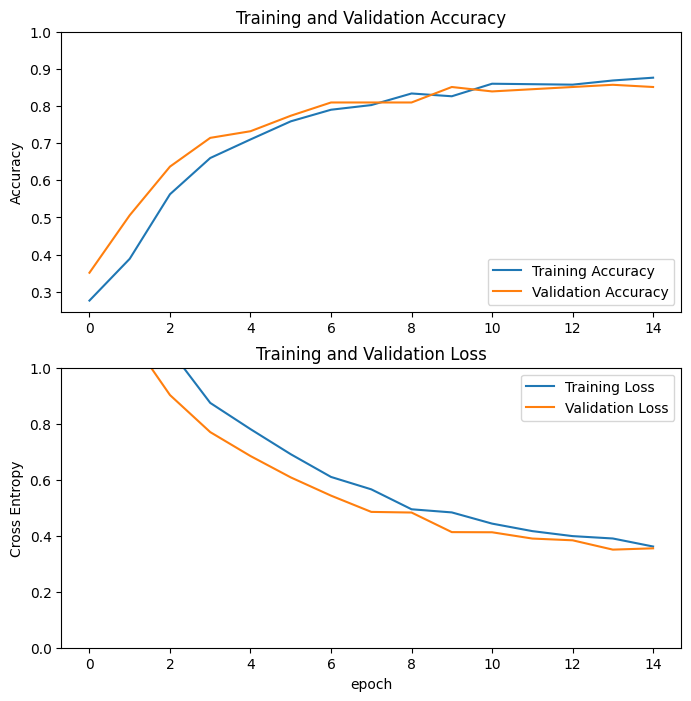

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 15/45
25/25 [==============================] - 20s 291ms/step - loss: 0.2693 - accuracy: 0.8875 - val_loss: 0.2584 - val_accuracy: 0.8750
Epoch 16/45
25/25 [==============================] - 10s 315ms/step - loss: 0.2007 - accuracy: 0.9137 - val_loss: 0.1574 - val_accuracy: 0.9167
Epoch 17/45
25/25 [==============================] - 8s 244ms/step - loss: 0.1768 - accuracy: 0.9388 - val_loss: 0.2248 - val_accuracy: 0.9048
Epoch 18/45
25/25 [==============================] - 10s 287ms/step - loss: 0.1431 - accuracy: 0.9513 - val_loss: 0.1448 - val_accuracy: 0.9226
Epoch 19/45
25/25 [==============================] - 9s 310ms/step - loss: 0.1425 - accuracy: 0.9425 - val_loss: 0.1942 - val_accuracy: 0.9167
Epoch 20/45
25/25 [==============================] - 8s 238ms/step - loss: 0.1018 - accuracy: 0.9737 - val_loss: 0.1256 - val_accuracy: 0.9464
Epoch 21/45
25/25 [==============================] - 10s 315ms/step - loss: 0.0914 - accuracy: 0.9700 - val_loss: 0.1061 - val_accuracy: 0.

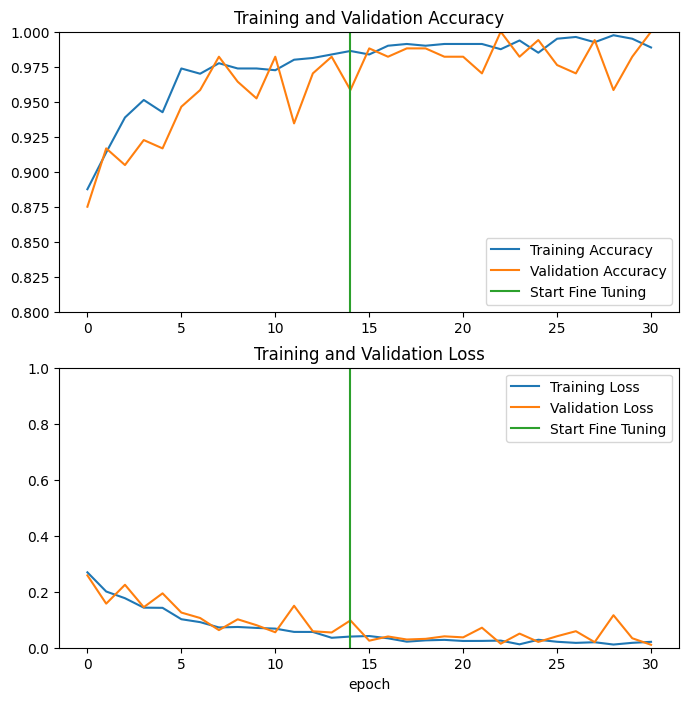

In [ ]:
# Initialize lists to accumulate values
acc = []
val_acc = []
loss = []
val_loss = []

# Accumulate values from each training run
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.0183 - accuracy: 1.0000
Test accuracy : 1.0


In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply softmax to convert logits to probabilities
predictions = tf.nn.softmax(predictions)

# Get the predicted class indices
predicted_class_indices = tf.argmax(predictions, axis=1)

print('Predictions:\n', predicted_class_indices.numpy()+1)
print('Labels:\n', label_batch+1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_class_indices[i]])
  plt.axis("off")


### Save Model

In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/gdrive/MyDrive/Skripsi/Saved Model/KlasifikasiUmurAyam.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
